In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import seaborn as sns 
from random import sample
import string

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
#from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


# Metrics
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay


#========================================================
# Set seed for reproducible results.
SEED = 2025
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
#==========================================================




/home/lrt/.local/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/lrt/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-07-02 15:29:01.763370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751484541.778571    2277 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751484541.7833

In [2]:
#!pip install nltk



In [3]:
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')



In [4]:
mainDir = os.getcwd
dataDir = os.chdir("data")




<h1 style="text-align: center; color: #8D7334; font-weight: bold; font-style: italic; text-decoration: underline; "> Disaster Tweet Detection with Recurrent Neural Networks (RNN)</h1>

<h2 style="text-align: center;  font-weight: bold; font-style: italic; text-decoration: underline; ">  University of Colorado Boulder </h2>
<h2 style="text-align: center;  font-weight: bold; font-style: italic; text-decoration: underline; ">  Master of Data Science </h2>
<h2 style="text-align: center;  font-weight: bold; font-style: italic; text-decoration: underline; ">  DTSA 5511 Introduction to Deep Learning -- Week 4 -- Final Project -- </h2>
<br>
<br>
<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;"> Introduction and Key Objectives:</h3>

The main objective of this project is to use Natural Language Processing (NLP) tools along with RNNs to determine whether a given tweet belongs to a disaster category or not. This is a binary classification problem. 

The related Kaggle competition and datset may be found in this link: https://www.kaggle.com/competitions/nlp-getting-started/



<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;"> Description of the dataset, Data Cleaning, Preprocessing, and EDA: </h3>


In [5]:
trainDF = pd.read_csv("train.csv")
testDF = pd.read_csv("test.csv")
trainDF = pd.read_csv("train.csv")
testDF = pd.read_csv("test.csv")
print("\nLine 37: trainDF\n", trainDF.info(),"\n", trainDF)
print("\nLine 37: testDF\n", testDF.info(), "\n", testDF)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB

Line 37: trainDF
 None 
          id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near

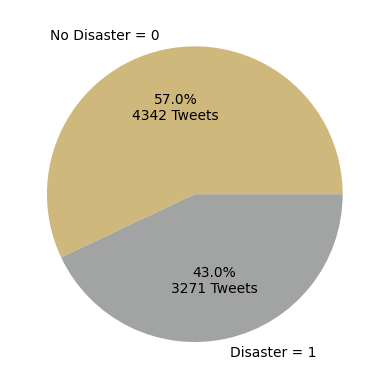

In [6]:
pieColors = ["#CFB87C", "#A2A4A3"]
uniqueLabels, countLabels = np.unique(trainDF.target.values, return_counts=True)
labels = ["No Disaster = 0", "Disaster = 1"]

def autopctFormat(values):
    def myFormat(pct):
        total = sum(values)
        valTemp = int(round(pct * total / 100.0))
        return f"{pct:.1f}%\n{valTemp:d} Tweets"
    return myFormat

plt.pie(countLabels, labels=labels, autopct=autopctFormat(countLabels), colors=pieColors)
plt.show()

The data sets have 5 features: id, keyword, location, text, and target. We seek to infer whether or not the text is related to a disaster. Location may be useful to disaster responders and authorities once we establish that the tweet is related to one. But not for the purpose of classification. Location (5068 non NaN records, vs 7613 total) is also not always present in the data. The same happens with the keyword feature too. Keyword attempts to classify (or pre classify). In many ways keyword is already an inference about what is important or relevant to that one tweet. For the purpose of the binary classification I am pursuing I prefer to base the models and later inferences on the raw data --as opposed to on an inference made such as keyword may be--.

I will be dropping the features keyword and location.

The target feature will be either a 0 (not a disaster related tweet) or 1 (a disaster related tweet).

The train set has 7613 samples and the test set 3263.

The training data is roughly balanced with 43% of tweets indicating a disaster event.

In [7]:
trainDF = trainDF.drop(columns=["keyword", "location"])


Let's take a look at a sample of tweets to get a feel of how long they are and what further cleaning might be needed:

In [8]:
trainDF['txtLen'] = trainDF["text"].apply(len)
testDF['txtLen'] = testDF["text"].apply(len)

np.random.seed(2025)
txtSample = np.random.randint(0, trainDF.shape[0], 70) # about 1% of the total dataset
for i in txtSample:
    print(trainDF.iloc[i]['target'], ",", trainDF.iloc[i]['text'], ",", trainDF.iloc[i]['txtLen'])



1 , NWS has Continued a Severe Thunderstorm Warning for Oklahoma-OK until 10:30 PM , 78
0 , When a real nigga hold you down you supposed to drown , 53
0 , @paddytomlinson1 ARMAGEDDON , 27
0 , #Pandemonium.iso psp http://t.co/HbpNFOAwII , 43
0 , ball has no curfew https://t.co/SG1FTKaEgq , 42
1 , Something Frightening is Happening to the Weather in the Middle East http://t.co/bDOTQ8dSlN , 91
0 , Now playing: Darude - Sandstorm - radio edit http://t.co/DUdAIrBBPo http://t.co/padosfyXnM , 90
0 , @Surf_Photo I squeezed a tear. Famine plague tsunami no chance. Lego - blubber! , 79
0 , @Deeeznvtzzz bring the body bags tho , 36
1 , Fire hazard associated with installation of non-compliant external cladding on http://t.co/bTPQdehl3p - By @www.cbplawyers , 122
0 , Spot Flood Combo 53inch 300W Curved Cree LED Work Light Bar 4X4 Offroad Fog Lamp - Full reÛ_ http://t.co/O097vSOtxk http://t.co/I23Xy7iEjj , 139
0 , @JoseBasedGod I'm obliterate you to the shadow realm. , 53
1 , Condemnation clearly 

We can see from the sample that the tweets contain links, punctuation, and handle characters which are not usefull to determine a binary disaster class. The cleaning function below will remove these characters and produce a list of clean words which will then enable further classification.


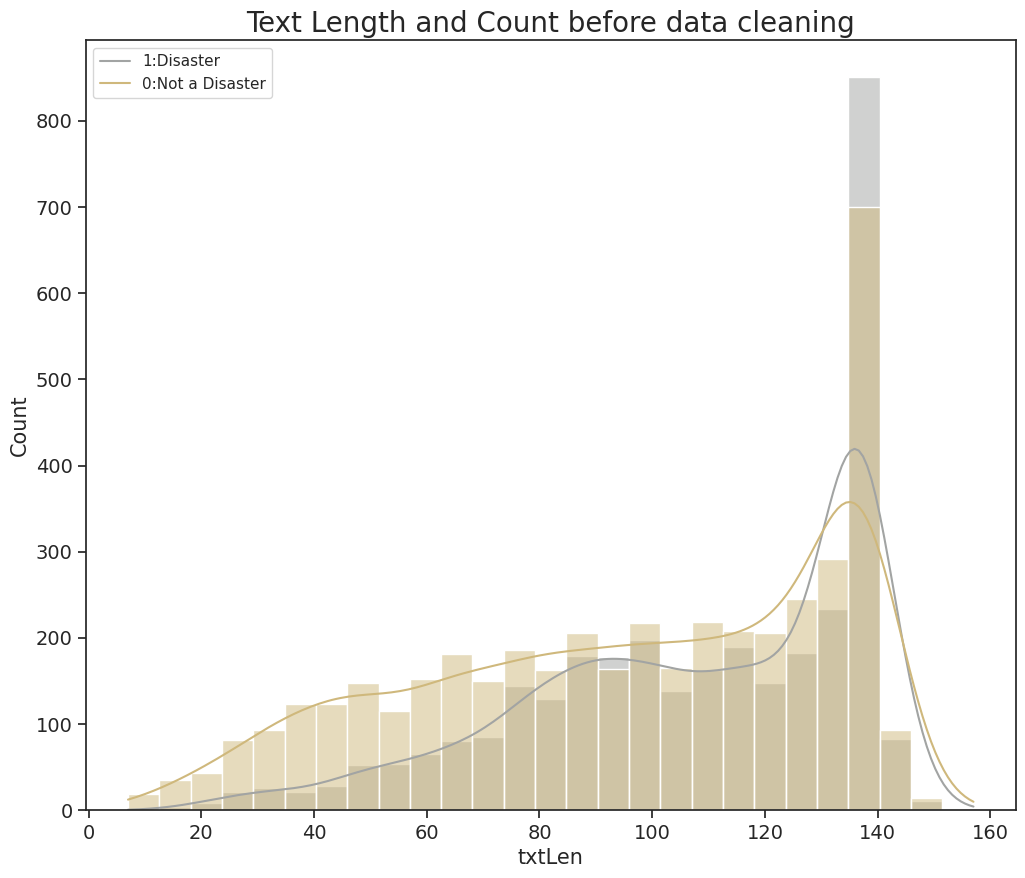

In [9]:
def disasterClass(df, title, feature, color):
    sns.set(rc={"figure.figsize":(12, 10)})
    sns.set_style("ticks")
    plot = sns.histplot(
        data = df, 
        x = feature,
        kde = True,
        hue = 'target',
        palette = color,
        hue_order=[0,1]  # Set the order of target values
        )
    plot.set_xlabel('txtLen', fontsize = 15)
    plot.set_ylabel('Count', fontsize = 15)
    plot.set_title(title, fontsize = 20)
    plt.tick_params(labelsize = 14)
    plt.legend(loc='upper left',labels = ['1:Disaster', '0:Not a Disaster'])
    plt.show()
disasterClass(trainDF, "Text Length and Count before data cleaning", 'txtLen', ["#CFB87C", "#A2A4A3"]) # [gold, grey)




[3663, 5115]

Line 168
    id                                               text  target  txtLen  \
0   1  Our Deeds are the Reason of this #earthquake M...       1      69   
1   4             Forest fire near La Ronge Sask. Canada       1      38   
2   5  All residents asked to 'shelter in place' are ...       1     133   
3   6  13,000 people receive #wildfires evacuation or...       1      65   
4   7  Just got sent this photo from Ruby #Alaska as ...       1      88   

                                            wordList  listLen  
0   [deeds, reason, earthquake, may, allah, forgive]        6  
1          [forest, fire, near, ronge, sask, canada]        6  
2  [residents, asked, shelter, place, notified, o...       11  
3  [people, receive, wildfires, evacuation, order...        6  
4  [got, sent, photo, ruby, alaska, smoke, wildfi...        9  


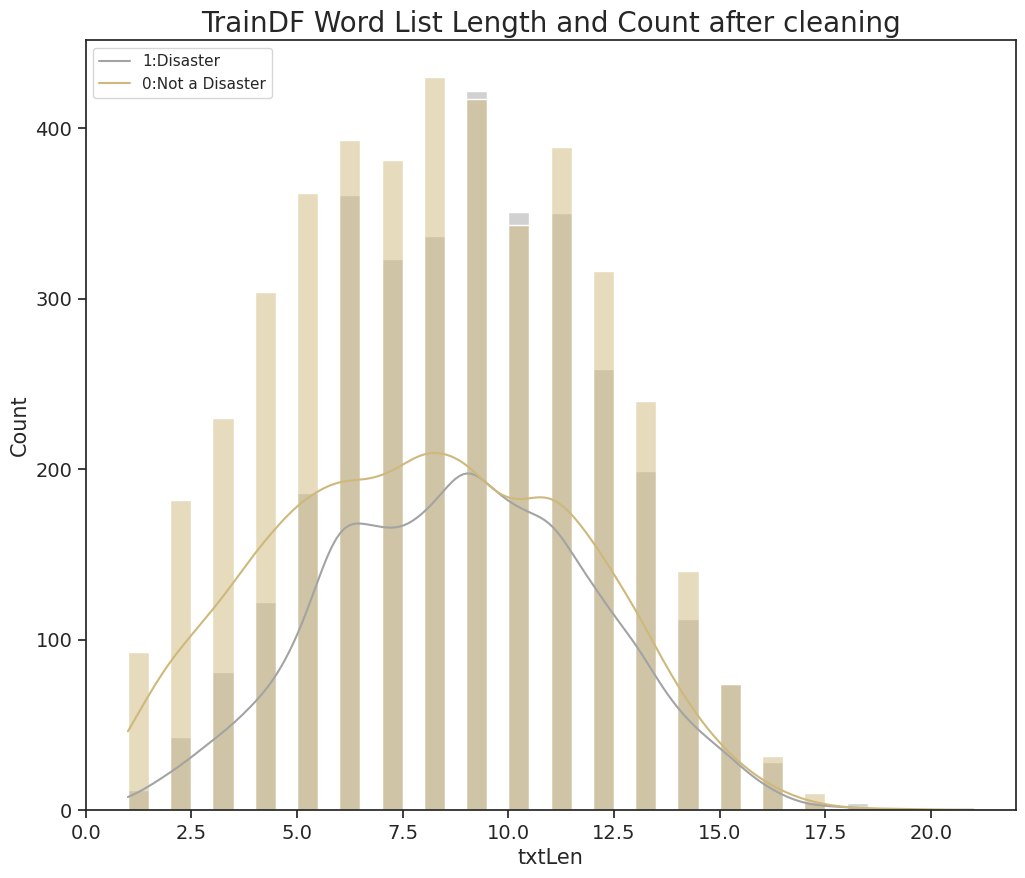

In [10]:
# Function adapted from Ken McCarthy's paper.

def cleanText(fullText):
# Make all text in the string lowercase, remove spaces and lines:
    fullText = fullText.lower()
    fullText = fullText.replace("\n", " ")
    
    # Split the text at each space and remove all user handles containing @ and strings containing "http":
    wordListTemp0 = fullText.split(" ")
    wordListTemp1 = []
    for word in wordListTemp0:
        if "@" not in word and "http" not in word:
                wordListTemp1.append(word)
    #wordListTemp1 = fullText
    
    # Remove all punctuation
    translation = str.maketrans('', '', string.punctuation + "£")
    wordListTemp2 = []
    for word in wordListTemp1:
           wordListTemp2.append(word.translate(translation))
    
    # Remove all words with two or less characters, any words containing numbers, and any stopword.
    wordListTemp3 = []
    for word in wordListTemp2:
        if len(word) >= 3 and not any(char.isdigit() for char in word) and word not in stopwords.words('english'):
            wordListTemp3.append(word)
            
    # Remove spaces in each word:
    wordListTemp4 = [word.replace(" ", "") for word in wordListTemp3]
    wordListTemp4 = []
    for word in wordListTemp3:
        wordListTemp4.append(word.replace(" ", ""))
    
    return wordListTemp4

# Clean Train DF:
cleanWordList = []
listLenTemp = []
idxTrain = []
for i in range(trainDF.shape[0]):
    cleanListTemp = cleanText(trainDF.iloc[i]['text'])
    cleanWordList.append(cleanListTemp)
    listLenTemp.append( len(cleanListTemp))
    if( len(cleanListTemp) == 0):
        idxTrain.append(i)
print(idxTrain)

trainDF["wordList"] = cleanWordList
trainDF["listLen"] = listLenTemp
trainDF = trainDF.drop(idxTrain)
print("\nLine 168\n", trainDF.head())

disasterClass(trainDF, "TrainDF Word List Length and Count after cleaning", 'listLen', ["#CFB87C", "#A2A4A3"]) # [gold, grey)



We can see that the count of text length is more evenly (normally) distributed after the tweets were boiled down to a list of relevant words.

The next step of pre-processing is to shape the data to fit the input format of RNN. This is called tokenizing the dataset.

The Keras Tokenizer is a utility class designed to convert raw text into sequences of integers, where each integer represents a token (usually a word) indexed in a dictionary built from the text data. https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

I apply the tokenizer to the clean list of words, and each word is assigned an integer number based on the frequency of that word in the overall text. The most frequent tokens get a lower number. 

The integer sequences produced by the tokenizer become inputs for later Keras layers like Embedding, which maps these integers to dense vector representations for neural network training.


In [11]:
vocabSize = 150000 # 7500 tweets, with max 20 clean words each. 
tokenizer=Tokenizer(num_words=vocabSize, split=',')
tokenizer.fit_on_texts(trainDF['wordList'].values)
#tokenizer.fit_on_sequences(trainDF['wordList'].values)
X = tokenizer.texts_to_sequences(trainDF['wordList'].values)
X = pad_sequences(X) # makes the size of the token vector equal to the length of the longest list in wordList.
print("\nLine 191: Tokenization example of the 1st tweet.\n", trainDF['wordList'][1005], "\n", X[1005], len(X[1005]))
y = trainDF['target']



Line 191: Tokenization example of the 1st tweet.
 ['another', 'one', 'another', 'one', 'still', 'aint', 'done', 'shit', 'one', 'nigga', 'body', 'bagging', 'meek'] 
 [   0    0    0    0    0    0    0    0   80    8   80    8   16  776
  468  115    8 1015   17  425  696] 21


I will now split the traning set into a pure training set and a validation set.

In [12]:
trainX, validX, trainY, validY = train_test_split(X, y, test_size = 0.35, random_state = 2025)


<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;"> Long Short Term Memory (LSTM) Model: </h3>

An LSTM model (Long Short-Term Memory) is a type of recurrent neural network (RNN) designed to learn from sequential data by retaining information over long time intervals. LSTMs are  effective for tasks involving time series, natural language processing, and any data where context and order matter.

LSTM models use special units called memory cells that can maintain information in memory for long periods, overcoming the vanishing gradient problem common in standard RNNs.

Each cell in the model has gates (input, forget, output) that control the flow of information, allowing the model to decide what to keep or discard at each time step.

Keras provides a straightforward API for creating LSTM models. 


In [13]:

# https://keras.io/api/layers/recurrent_layers/lstm/
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
# https://medium.com/analytics-vidhya/lstms-explained-a-complete-technically-accurate-conceptual-guide-with-keras-2a650327e8f2
# https://www.geeksforgeeks.org/deep-learning/tf-keras-layers-lstm-in-tensorflow/

# Hyperparameters
#vocabSize = 10000      # Number of unique tokens in your vocabulary
timesteps = 21        # Length of input sequences (number of tokens per sample). For us, this is the length of the longest clean word list.
embedding_dim = 64     # Size of embedding vectors
lstm_units = 50        # Number of LSTM units
dropout_rate = 0.2     # Dropout rate
lr1 = 0.0001  # Learning rate for the optimizer

# Model definition
lstm1 = Sequential()
lstm1.add(Embedding(input_dim=vocabSize, output_dim=embedding_dim)) #, input_length=timesteps))
lstm1.add(LSTM(lstm_units, return_sequences=True))
lstm1.add(Dropout(dropout_rate))
lstm1.add(LSTM(lstm_units))
lstm1.add(Dropout(dropout_rate))
lstm1.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for classifcation
adam = optimizers.Adam(learning_rate=lr1)
lstm1.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])


# Model training
# Define callbacks
callbacks1 = [
    ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0, verbose=1),
    EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5, verbose=1, restore_best_weights=True)
]

# Train the model
historyLSTM1 = lstm1.fit(
    trainX, trainY,
    epochs=10,
    batch_size=32,
    validation_data=(validX, validY),
    callbacks=callbacks1
)


#ReduceLROnPlateau: Reduces the learning rate when val_loss has stopped improving for 5 epochs.

#EarlyStopping: Stops training if val_accuracy doesn't improve by at least 1e-4 for 5 epochs, and restores the best weights.

#callbacks=callbacks: Passes the list of callbacks to the fit method.

# Epoch 5 delivers the best validation accuracy at 77.74%

Epoch 1/10


2025-07-02 15:33:08.245559: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


155/155 ━━━━━━━━━━━━━━━━━━━━ 26s 151ms/step - accuracy: 0.5563 - loss: 0.6865 - val_accuracy: 0.5721 - val_loss: 0.6738 - learning_rate: 1.0000e-04
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 24s 155ms/step - accuracy: 0.5647 - loss: 0.6720 - val_accuracy: 0.5867 - val_loss: 0.6588 - learning_rate: 1.0000e-04
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 24s 155ms/step - accuracy: 0.6368 - loss: 0.6437 - val_accuracy: 0.7128 - val_loss: 0.6010 - learning_rate: 1.0000e-04
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 23s 149ms/step - accuracy: 0.7996 - loss: 0.5193 - val_accuracy: 0.7541 - val_loss: 0.5122 - learning_rate: 1.0000e-04
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 24s 154ms/step - accuracy: 0.8608 - loss: 0.3471 - val_accuracy: 0.7808 - val_loss: 0.5068 - learning_rate: 1.0000e-04
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 24s 155ms/step - accuracy: 0.8933 - loss: 0.2713 - val_accuracy: 0.7718 - val_loss: 0.5245 - learning_rate: 1.0000e-04
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 24s 154ms/step - 

<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;"> Gated Recurrent Unit (GRU) Model: </h3>

GRU is a type of recurrent neural network (RNN) architecture introduced by Kyunghyun Cho et al. in 2014 to address the vanishing gradient problem in traditional RNNs. GRUs updates gate and resets gate to control the flow of information, allowing the network to capture both short-term and long-term dependencies in sequential data.

In [14]:
# Hyperparameters GRU model
timesteps = 21         # Length of input sequences
embedding_dim = 64     # Embedding vector dimension
gru_units = 128         # GRU units
dropout_rate = 0.2     # Dropout rate
lr2 = 0.0001  # Learning rate

# Model definition
gru1 = Sequential()
gru1.add(Embedding(input_dim=vocabSize, output_dim=embedding_dim)) #, input_length=timesteps))
gru1.add(GRU(gru_units, return_sequences=True))
gru1.add(Dropout(dropout_rate))
gru1.add(GRU(gru_units))
gru1.add(Dropout(dropout_rate))
gru1.add(Dense(20, activation='relu'))
gru1.add(Dense(1, activation='sigmoid'))  # For binary classification

adam = optimizers.Adam(learning_rate=lr2)
gru1.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks2 = [
    ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0, verbose=1),
    EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5, verbose=1, restore_best_weights=True)
]

# Model training
historyGRU1 = gru1.fit(
    trainX, trainY,
    epochs=10,
    batch_size=16,
    validation_data=(validX, validY),
    callbacks=callbacks2
)



Epoch 1/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 52s 158ms/step - accuracy: 0.5654 - loss: 0.6840 - val_accuracy: 0.6663 - val_loss: 0.6370 - learning_rate: 1.0000e-04
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 49s 158ms/step - accuracy: 0.7416 - loss: 0.5586 - val_accuracy: 0.7508 - val_loss: 0.5175 - learning_rate: 1.0000e-04
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - accuracy: 0.8582 - loss: 0.3387 - val_accuracy: 0.7767 - val_loss: 0.5226 - learning_rate: 1.0000e-04
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - accuracy: 0.9081 - loss: 0.2411 - val_accuracy: 0.7620 - val_loss: 0.5903 - learning_rate: 1.0000e-04
Epoch 5/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - accuracy: 0.9346 - loss: 0.1752 - val_accuracy: 0.7523 - val_loss: 0.6896 - learning_rate: 1.0000e-04
Epoch 6/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 49s 158ms/step - accuracy: 0.9511 - loss: 0.1325 - val_accuracy: 0.7500 - val_loss: 0.7430 - learning_rate: 1.0000e-04
Epoch 7/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 154

<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;"> LSTM vs GRU Comparison: </h3>


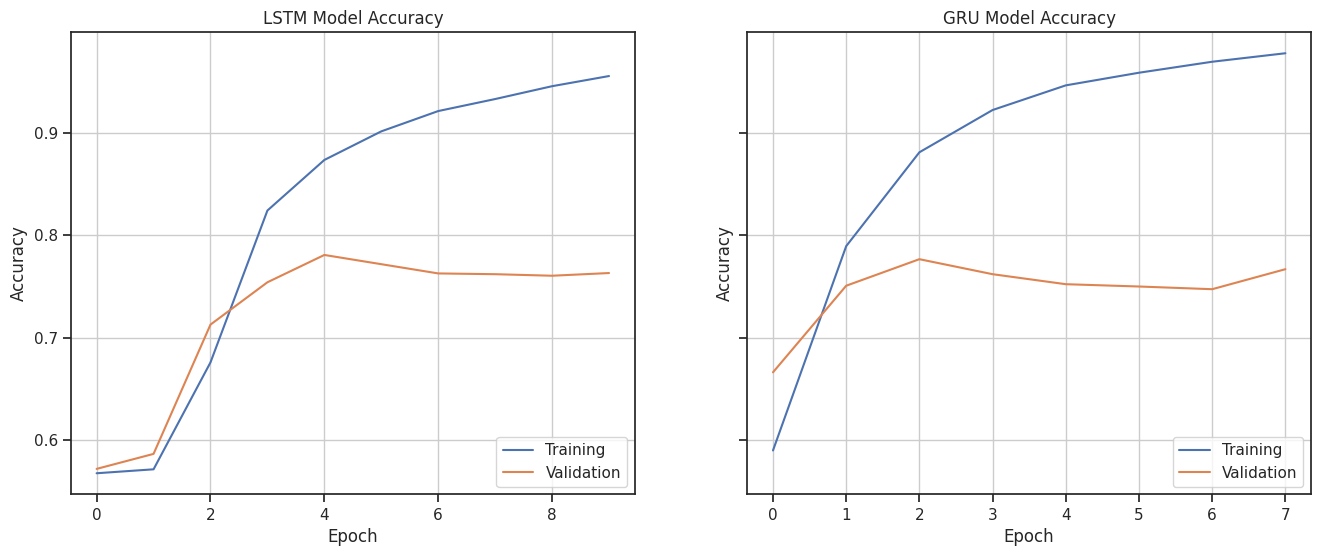

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# LSTM Accuracy
axs[0].plot(historyLSTM1.history['accuracy'], label='Training')
axs[0].plot(historyLSTM1.history['val_accuracy'], label='Validation')
axs[0].set_title('LSTM Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')
axs[0].grid()

# GRU Accuracy
axs[1].plot(historyGRU1.history['accuracy'], label='Training')
axs[1].plot(historyGRU1.history['val_accuracy'], label='Validation')
axs[1].set_title('GRU Model Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend(loc='lower right')
axs[1].grid()

Based on the comparison charts above, the models reach very similar and stable validation accuracies as roughly 76%, with LSTM slightly higher. The LSTM chart suggests that the training accuracy still has potential to grow. However, with a plateu on validation accuracy, we would expect that such improvement in training accuracy would not translate into higher validation accuracy.

I will keep the LSTM model as a better one.

<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;"> Tuning of Hyperparameters: </h3>
I have tested several learning rates, and the one selected delivers a good balance between accuracy and computing time for this purpose. I started with a learning rate of 0.002 and gradually reduced it to 0.0001. A much lower learning rate than that one backfires and does not deliver higher validation accuracy, most likely due to the other early stop parameters settings.

I will explore epochs and batch size to see if improvements in validation accuracy can be achieved.


Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - accuracy: 0.8933 - loss: 0.2685 - val_accuracy: 0.7733 - val_loss: 0.5060 - learning_rate: 1.0000e-05
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.8991 - loss: 0.2643 - val_accuracy: 0.7725 - val_loss: 0.5082 - learning_rate: 1.0000e-05
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.8964 - loss: 0.2608 - val_accuracy: 0.7725 - val_loss: 0.5104 - learning_rate: 1.0000e-05
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.8946 - loss: 0.2595 - val_accuracy: 0.7721 - val_loss: 0.5119 - learning_rate: 1.0000e-05
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - accuracy: 0.8967 - loss: 0.2609 - val_accuracy: 0.7718 - val_loss: 0.5135 - learning_rate: 1.0000e-05
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8987 - loss: 0.2575
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.898

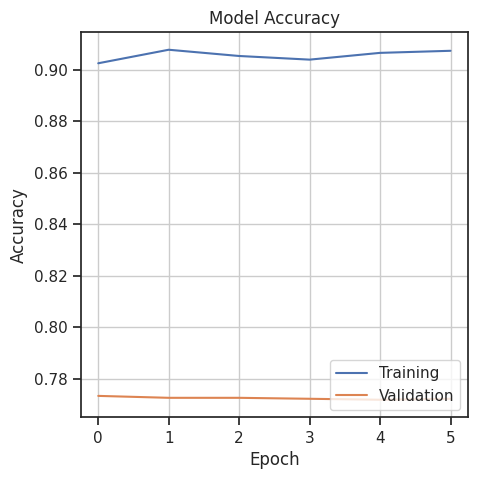

In [16]:
# Train the model with new parameters:
historyLSTM2 = lstm1.fit(
    trainX, trainY,
    epochs=20,
    batch_size=128,
    validation_data=(validX, validY),
    callbacks=callbacks1
)

plt.figure(figsize=(5, 5))
plt.grid()
plt.plot(historyLSTM2.history['accuracy'], label='Training')
plt.plot(historyLSTM2.history['val_accuracy'], label = 'Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


The tuning of epoch didn't really improve validation accuracy since the model was already early stopping anyway. Increasing the batch size did have a positive effect, and improved validation accuracy into the 78% mark when set at 128. Increasing the batch size further did not improve validation accuracy.


<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;"> Confusion Matrix : </h3>






84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


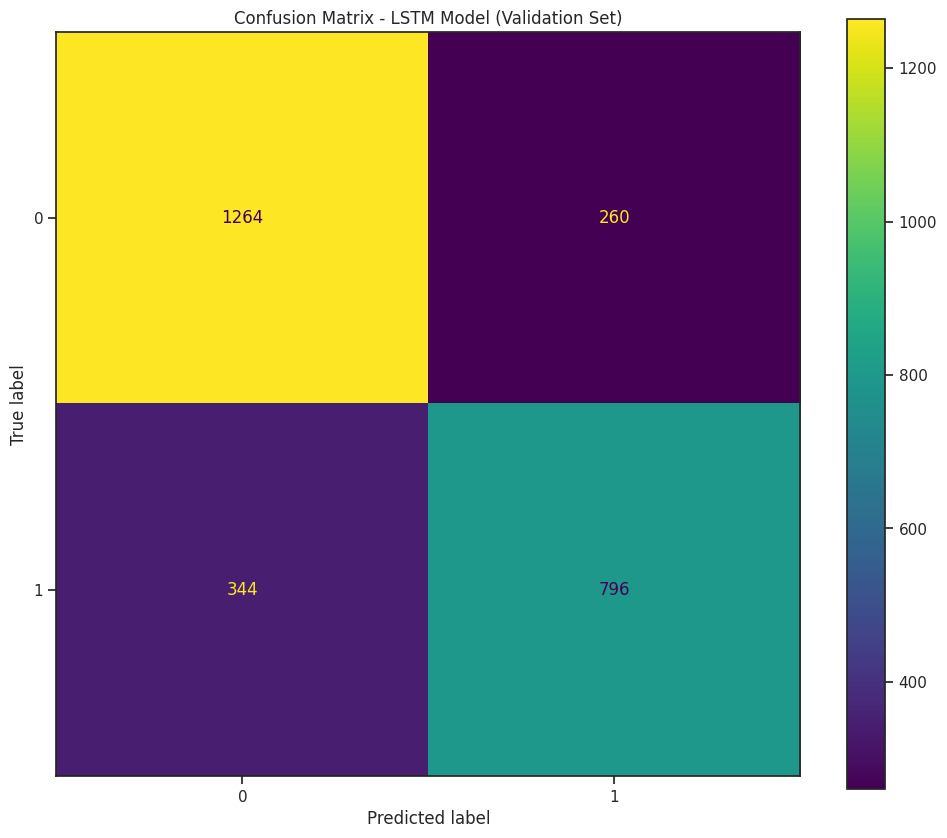

In [17]:
yValidPredProb = lstm1.predict(validX)
yValidPred = (yValidPredProb > 0.5).astype(int).flatten()

lstm1CM = confusion_matrix(validY, yValidPred)

dispCM = ConfusionMatrixDisplay(confusion_matrix=lstm1CM, display_labels=[0, 1])
dispCM.plot()
plt.title('Confusion Matrix - LSTM Model (Validation Set)')
plt.show()




We can see that there are 1302+222 = 1524 tweets not related to a disaster; of which 1302 are correctly classified. The 222 are tweets not related to a disaster, classified as disaster tweets. This type of error should not be a source of concern, since a follow up by authorities should fairly quickly resolve any questions about whether or not there is a disaster in the making.

We can also observe from the matrix that there are 348+792 = 1140 tweets related to a disaster; of which 348 (about 30%) are missclasified as not related to one. This is more problematic, since a disaster that is in the making may not be immediately identified by the model. This is an obvious area to improve in future iterations of this project. 


<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;"> Prediction on Test Set : </h3>


In [ ]:
# Clean Test DF:
cleanWordList = []
listLenTemp = []
idxTest = []
for i in range(testDF.shape[0]):
    cleanListTemp = cleanText(testDF.iloc[i]['text'])
    cleanWordList.append(cleanListTemp)
    listLenTemp.append( len(cleanListTemp))
    if( len(cleanListTemp) == 0):
        idxTest.append(i)
print(idxTest)

testDF["wordList"] = cleanWordList
testDF["listLen"] = listLenTemp
#testDF = testDF.drop(idxTest)
print("\nLine 170\n", testDF.head())


#Tokenixation on full test dataset
tokenizer.fit_on_texts(testDF['wordList'].values)
testX = tokenizer.texts_to_sequences(testDF['wordList'].values)
testX = pad_sequences(testX, maxlen = 21)

testY = lstm1.predict(testX).round() # yHat


<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;"> Prepare submission File: </h3>


In [ ]:
# Prepare Submission File:
submissionDF = pd.read_csv("sample_submission.csv")
print(submissionDF.info(), submissionDF.head())
submissionDF['target'] = np.round(testY).astype('int') 
submissionDF.to_csv('submission.csv', index=False)
print("\nLine 335 : submissionDF\n", submissionDF.info(), "\n", submissionDF.head())


<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;"> Summary and Conclussions: </h3>

The dataset of text tweets was downloaded, clean, and converted into into a list of meaningful words representing each tweet. Each list of words was then tokenized to a format suitable for keras to fit a recurrent neural network model. Two different RNN models were fitted to a training set and validated for accuracy at 78%, with tuning of hyperparameters. The LSTM model performed better than GRU and was used to predict on the test set. 

The confusion matrix built on the validation set shows that there are 348+792 = 1140 tweets related to a disaster; of which 348 (about 30%) are missclasified as not related to one. indicates that a disaster that is in the making may not be immediately identified by the model. This is an obvious area to improve in future iterations of this project. 

The final submission file was prepared for submission and the output is presented above.

<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;"> References: </h3>

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

https://keras.io/api/layers/recurrent_layers/lstm/

https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

https://medium.com/analytics-vidhya/lstms-explained-a-complete-technically-accurate-conceptual-guide-with-keras-2a650327e8f2

https://www.geeksforgeeks.org/deep-learning/tf-keras-layers-lstm-in-tensorflow/

Kaggle competition: https://www.kaggle.com/competitions/nlp-getting-started

kaggle1: https://github.com/clayv/DTSA-5511_Week4/blob/main/README.md

kaggle2: https://annasanders.github.io/ms_projects/dtsa5511_nlpdisaster

kaggle3: https://github.com/EthanJTucker/DTSA_5511_HW/blob/main/Week4/LTSM_Project.ipynb

kaggle4: https://github.com/EdouardRobeyns/-DTSA-5511_Week4

kaggle5: https://github.com/KenMcCarthy24/DTSA_5511_Disaster_Tweets/blob/main/Disaster%20Tweet%20Classification.ipynb

kaggle6: https://github.com/IvMonares/NLP_Disaster_Tweets/blob/main/Regression%20Networks.ipynb

kaggle7: https://github.com/Chiuchiyin/NLP-with-Disaster-Tweets/blob/main/LTSM_Project.ipynb

kaggle8: https://github.com/bryanpmayfield/dtsa_5511_NLP_Disaster_Tweets/blob/main/dtsa-week-4-peer-review-assignment-nlp-disaster-tw.ipynb

kaggle9: https://github.com/clebastard21/DTSA-5511-NLP-with-Disaster-Tweets/blob/main/DTSA%205511%20-%20Week%204.pdf

kaggle10: https://github.com/akirahanada/DTSA5511_Week4_notebook_Tweet_NLP_Project/blob/main/DTSA5511_Week4_notebook_Tweet_NLP_Project.ipynb

kaggle11: https://github.com/Josiah4Jesus/JosiahBall_DTSA5511_Module4_RNN_DisasterTweets/blob/main/JosiahBall_DTSA5511_Module4_RNN_DisasterTweets.ipynb

kaggle12: https://github.com/alexmohelsky/dtsa-5511-w4-DisasterTweets/blob/main/README.md

